In [1]:
from IPython.display import Image

# overview

https://github.com/MathFoundationRL/Book-Mathematical-Foundation-of-Reinforcement-Learning
- chap1：基本概念
- chap2-chap8：**value-based** methods
    - 先估计值再得到最优策略；
    - chap2-3：Bellman equation
    - chap4：VI（Value Iteration）& PI（Policy Iteration）
    - chap5：MC (model-free)
    - chap7：TD
- chap9-10：**policy-based** methods，直接优化关于策略参数 $\pi_\theta(a|s)$ 的目标函数
    - chap9：PG（policy gradient）
        - 策略梯度定理
            - simple code：
                - https://www.datacamp.com/tutorial/policy-gradient-theorem
    - chap10：Actor-Critic (A2C)，融合了基于策略和基于价值的两类方法
        - Actor：策略更新
        - Critic：价值更新

# highlights

> 从现代应用的视角，rlhf (ppo), rl4llm (ppo-variants)

## Core Concepts

### $R_t$ vs. $G_t$

$$
\begin{split}
&J(\theta) = E[G_t]=E[G_0]\\
&J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta}[G_0] = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^{T-1} \gamma^t R_{t+1} \right]
\end{split}
$$

- 智能体的目标不是最大化瞬时奖励 $R_t$，而是最大化累积奖励。
- 奖励（reward，$R_t$）与回报（return，$G_t$）
    - $R_t$：智能体在特定时间点 $t$ 完成某个动作后**立即**给予的反馈。
    - $G_t$：回报是衡量从某一时刻开始，直到“一局游戏”结束，智能体能够获得的“总奖励”是多少。因为未来的奖励可能不如眼前的奖励那么确定或有价值，我们通常会给未来的奖励打个折扣。

### value/adavantage function 

- 状态价值函数：$V(s)$
    - $V_π(s) = E_π[G_t | S_t = s]$
- 动作值函数: $Q(s,a)$
    - $Q_π(s,a) = E_π[G_t | S_t = s, A_t = a]$
    - $G_t$ 是对 $Q^{\pi_\theta}(s_t, a_t)$ 的无偏采样。
- 优势函数 (Advantage Function, $A(s,a)$)
    - $A_π(s,a) = Q_π(s,a) - V_π(s)$

### Bellman equation

贝尔曼期望方程 (Bellman Expectation Equations)

$$
\begin{split}
V^\pi(s) &= \sum_{a \in A} \pi(a|s) \sum_{s', r} P(s', r | s, a) [r + \gamma V^\pi(s')]\\
Q^\pi(s,a) &= \sum_{s', r} P(s', r | s, a) [r + \gamma \sum_{a' \in A} \pi(a'|s') Q^\pi(s',a')]\\
V(s) &= \sum_{a\in A}\pi(a|s)Q(s,a)
\end{split}
$$
或者，更简洁地，如果 $V^\pi(s')$ 已知： $Q^\pi(s,a) = \sum_{s', r} P(s', r | s, a) [r + \gamma V^\pi(s')]$.

它为特定策略 π 下的状态价值函数 $V_π$ (或动作价值函数 $Q_π$) 提供了一个自洽的递归定义：当前状态的价值等于遵循该策略所能获得的即时奖励，加上所有可能的下一状态的折扣价值的期望。其关键作用是作为评估一个给定策略好坏的数学基石：通过求解该方程，可以精确计算出在该策略指导下，从每个状态出发能获得的长期期望回报，从而量化策略的性能，并成为策略迭代等算法中“策略评估”步骤的理论核心。

----

贝尔曼最优方程 (Bellman Optimality Equations):

$$
\begin{split}
V(s) = \max_a \sum_{s', r} P(s', r | s, a) [r + \gamma V^(s')]\\
Q(s,a) = \sum_{s', r} P(s', r | s, a) [r + \gamma \max_{a'} Q(s',a')]
\end{split}
$$ 且 $V(s) = \max_a Q(s,a)$

-----

想象你是一个寻宝者，在一张藏宝图（代表环境）上寻找价值最高的宝藏。地图上有很多地点（状态），你可以从一个地点移动到另一个地点（动作），每次移动可能会得到一些小奖励或付出一些代价，最终目标是找到一条路径，使得总奖励最大。

- 值迭代 (Value Iteration, VI)：先搞清楚每个地点有多“值钱”，再决定怎么走。
    - 迭代的是价值函数	
- 策略迭代 (Policy Iteration, PI)：先定个初步的行走计划，然后评估这个计划好不好，再改进计划，如此循环。
    - 迭代的是策略 (虽然中间会计算价值函数)

值迭代算法直接将贝尔曼最优方程转化为一个迭代更新规则来寻找最优状态值函数 $V^*(s)$

- $V_{k+1}(s) \leftarrow \max_a \sum_{s', r} P(s', r | s, a) [r + \gamma V_k(s')]$

一旦得到 收敛后的值函数就是最优状态值函数 $V^*(s)$，就可以从中提取出最优策略 $\pi^*(s) = \arg\max_a \sum_{s', r} P(s', r | s, a) [r + \gamma V^*(s')]$

### MC vs. TD

当任务是分幕式 (episodic) 的，即有明确的开始和结束（比如一盘棋，一次走迷宫）。
- 智能体需要完整地采样一条轨迹 (trajectory) $\tau = (S_0, A_0, R_1, S_1, A_1, R_2, ..., S_{T-1}, A_{T-1}, R_T, S_T)$，其中 T 是终止状态的时间步。
- 对于这条轨迹中的每一步 t，回报 $G_t$ 计算如下： $G_t = R_{t+1} + γR_{t+2} + γ^2R_{t+3} + ... + γ^{T-t-1}R_T=\sum_{k=0}^{T-t-1}\gamma^kR_{t+k+1}$ 这里的 $R_{t+1}$ 是在状态 $S_t$ 执行动作 $A_t$ 后得到的即时奖励。$G_t$ 是从 $S_t$ 状态之后，未来所有步骤能获得的折扣奖励总和。
    - 计算的局限性，只要没抵达目标，就无法确定收益 $G_t$ 的值；

如果任务不是分幕式的 (continuing tasks)，或者我们不想等到整个 episode 结束才计算回报（比如在时序差分学习 TD learning 中）
- 回报 $G_t$ 通常会用值函数来估计。 例如，在一步 TD 学习中，回报 $G_t$ (也称为 TD 目标) 可以估计为： $G_t \approx R_{t+1} + γV(S_{t+1})$
    - 这里 $V(S_{t+1})$ 是对状态 $S_{t+1}$ 未来价值的一个估计。这就像是说：“我先拿上眼前的奖励 $R_{t+1}$，然后估计一下我到达的新状态 $S_{t+1}$ 大概还能带来多少未来的折扣奖励 $γV(S_{t+1})$。”

## PG

- 梯度方向，指向函数值增加最快的方向（梯度上升 => 最大化）：在函数定义域内的任何一点，该点的梯度向量所指的方向是函数值上升最陡峭的方向
    - $y=-x^2, y'=-2x$
        - $x\leftarrow x+0.01 y'$
            - $x=1, x=1-0.02$，向左移动（向 0 点靠近）
            - $x=-1, x=-1+0.02$，向右移动（向 0 点靠近）
    - $\theta = \theta + α * ∇_θ f(θ)$
    - 梯度下降（gradient descent），沿着梯度的反方向，最小化目标；
        - $\theta = \theta - α * ∇_θ f(θ)$
- $∇_θ \log π_θ(A_t|S_t)$ 本身的方向就是使得 $π_θ(A_t|S_t)$ 增加的方向。
    - $\nabla_\theta \log\pi_\theta=\frac{\nabla_\theta \pi_\theta}{\pi_\theta}$, $\pi_\theta$ 概率密度函数一定是 $>0$ 的；
    - $\nabla_\theta \log\pi_\theta$ 方向与 $\nabla_\theta\pi_\theta$ 方向相同，这个梯度方向显然就是 $\pi_\theta$ 取值增加的方向
        - 提升 $\pi_\theta(a|s)$ 的概率；

$$
J(θ) = E[G_t]=E_{\tau\sim \pi_\theta}[G_0]
$$

- https://en.wikipedia.org/wiki/Policy_gradient_method
    - log-derivate trick：方便整理成策略的期望形式
        - $f'=f\nabla \log f=f\left(\frac{f'}{f}\right)$
        - $\nabla\pi_\theta=\pi_\theta\nabla_\theta\log\pi_\theta$

$$
\nabla_\theta J(\theta) = \mathbb{E}{\substack{s \sim d^{\pi\theta} \ a \sim \pi_\theta(\cdot|s)}} \left[ \nabla_\theta \log \pi_\theta(a|s) \cdot R(s,a) \right]
$$


- R 的常见形式及其期望下标：
    - $G_t$ (累积回报 Total Return): 这是 **REINFORCE** 算法中使用的形式。$\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^{T-1} \nabla_\theta \log \pi_\theta(a_t|s_t) G_t \right]$
        - $G_t=\sum_{k=t}^{T-1}\gamma^{k-t}r_k$
        - 如果在状态 $s_t$ 执行动作 $a_t$ 后，最终得到的未来总回报 $G_t$ 比较高，那么我们就应该增加在 $s_t$ 选择 $a_t$ 的概率（通过增大 $\log \pi_\theta(a_t|s_t)$）。反之，如果 $G_t$ 比较低，就减小选择该动作的概率。
        - 无偏估计：$G_t$ 是对 $Q^{\pi_\theta}(s_t, a_t)$ 的无偏采样。
            -  $Q^{\pi_\theta}(s_t, a_t) = \mathbb{E}_{\pi_\theta} [G_t | S_t=s_t, A_t=a_t] $
        - 高方差：$G_t$ 是通过采样一条完整的轨迹得到的，其随机性很大，导致梯度的方差很高，学习过程不稳定且收敛慢。
    - $Q^{\pi_\theta}(s,a)$: $\nabla_\theta J(\theta) = \mathbb{E}_{\substack{s \sim d^{\pi_\theta} \\ a \sim \pi_\theta(\cdot|s)}} \left[ \nabla_\theta \log \pi_\theta(a|s) Q^{\pi_\theta}(s,a) \right]$
        - Q AC（Q actor critic）涉及两个模型： $\pi_\theta(a|s)$, $Q_w(s,a)$
        - Critic 负责评估在某个状态下执行某个动作有多好（$Q_w(s,a)$），Actor 则根据 Critic 的评估来调整自己的动作选择概率。如果 Critic 说某个动作好，Actor 就更倾向于选择它。
        -  减小方差：$Q_w(s,a)$ 通常是基于更多经验学习得到的，相比单次采样的 $G_t$，它更为平滑，从而可以减小梯度的方差。
    - $A^{\pi_\theta}(s,a)$ (优势函数 Advantage Function): $\nabla_\theta J(\theta) = \mathbb{E}_{\substack{s \sim d^{\pi_\theta} \\ a \sim \pi_\theta(\cdot|s)}} \left[ \nabla_\theta \log \pi_\theta(a|s) A^{\pi_\theta}(s,a) \right]$
        - A2C（Advantage Actor Critic），涉及两个模型 $\pi_\theta(a|s)$, $V_w(s)$
        - $A^{\pi_\theta}(s,a) = Q^{\pi_\theta}(s,a) - V_w(s)$
            - 一种非常常见且有效的方式是使用 TD error 作为优势函数的估计： 对于一个在时间步 $t$ 的转移 $(s_t,a_t,r_{t+1},s_{t+1})$
                - $Q^{\pi_\theta}(s_t, a_t)$ 可以用一步 TD 目标来估计 $r_{t+1} + \gamma V_w(s_{t+1})$
                - 优势函数的估计 $\hat A_t$ 就变成了：$ \hat{A}_t = (r_{t+1} + \gamma V_w(s_{t+1})) - V_w(s_t) $
            - Actor($\pi_\theta(a|s)$) 根据 $\hat A_t$ 来更新其参数 $\theta$。如果 $\hat A_t\gt 0$，则增加 $\log \pi_\theta(a_t|s_t)$；反之则减少。
            - Critic($V_w(s)$)，学习去最小化 TD error，即让 $V(s_t)$ 尽可能接近 $r_{t+1} + \gamma V_w(s_{t+1})$
-----

$$
\begin{align*}
\nabla_\theta J(\theta) &\propto \sum_s d^{\pi_\theta}(s) \sum_a (\nabla_\theta \pi_\theta(a|s)) Q^{\pi_\theta}(s,a) \\
&\quad \text{(An intermediate step in Policy Gradient theorem derivation)} \\
\\
&\text{The log-derivative trick states: } \nabla_x f(x) = f(x) \nabla_x \log f(x). \\
&\text{Applying this with } f(x) = \pi_\theta(a|s) \text{ (the policy) and variable } \theta: \\
\nabla_\theta \pi_\theta(a|s) &= \pi_\theta(a|s) \nabla_\theta \log \pi_\theta(a|s). \\
\\
&\text{Substituting this identity back into the expression for } \nabla_\theta J(\theta): \\
\nabla_\theta J(\theta) &\propto \sum_s d^{\pi_\theta}(s) \sum_a \left( \pi_\theta(a|s) \nabla_\theta \log \pi_\theta(a|s) \right) Q^{\pi_\theta}(s,a) \\
&= \sum_s d^{\pi_\theta}(s) \sum_a \pi_\theta(a|s) \left[ \nabla_\theta \log \pi_\theta(a|s) Q^{\pi_\theta}(s,a) \right] \\
&= \mathbb{E}_{\substack{s \sim d^{\pi_\theta} \\ a \sim \pi_\theta(\cdot|s)}} \left[ \nabla_\theta \log \pi_\theta(a|s) Q^{\pi_\theta}(s,a) \right]
\end{align*}
$$

- $d^{\pi_\theta}(s)$: 在策略 $\pi_\theta$ 下的状态分布

### $∇_θ J(θ) \approx \sum_{t=0}^{T-1} \underbrace{∇_θ \log π_θ(A_t|S_t)}_{\text{方向}} \underbrace{G_t}_{\text{幅度与符号}}$

$$
\begin{split}
&θ \leftarrow θ + \alpha \cdot ∇_θ J(θ)\\
&θ \leftarrow θ + \alpha \cdot \left( \sum_{t=0}^{T-1} ∇_θ \log π_θ(A_t|S_t) G_t \right)
\end{split}
$$

- 如果 $G_t$ 是正的且较大，说明从 $(S_t, A_t)$ 开始的后续表现很好，那么我们就希望增加在 $S_t$ 状态下选择 $A_t$ 动作的概率。
    - $\pi_\theta(A_t|S_t)\uparrow$
    - $∇_θ \log π_θ(A_t|S_t) \cdot G_t$ 与 $∇_θ \log π_θ(A_t|S_t)$ 方向相同
- 如果 $G_t$ 是负的或较小，说明后续表现不好，那么我们就希望减少在 $S_t$ 状态下选择 $A_t$ 动作的概率。
    - $\pi_\theta(A_t|S_t)\downarrow$
    - $∇_θ \log π_θ(A_t|S_t) \cdot G_t$ 与 $∇_θ \log π_θ(A_t|S_t)$ 方向相反

### TRPO & PPO

#### on-policy vs. off-policy

- IS (importance sampling)：ratio 从哪里来的
$$
\begin{align*}
\mathbb{E}_{x \sim p}[f(x)] &= \int p(x)f(x)dx \\
&= \int q(x) \frac{p(x)}{q(x)} f(x)dx \\
&= \mathbb{E}_{x \sim q}\left[\frac{p(x)}{q(x)}f(x)\right]
\end{align*}
$$

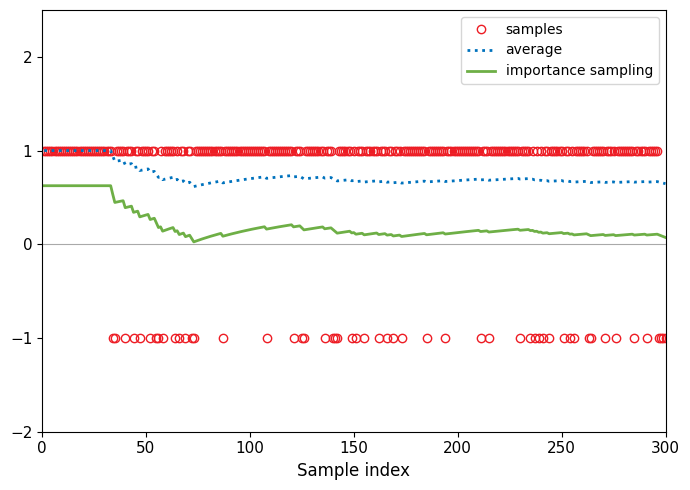

In [4]:
import numpy as np
import matplotlib.pyplot as plt

N_SAMPLES = 300  # 样本数量
p0_dist = {1: 0.5, -1: 0.5}
p1_dist = {1: 0.8, -1: 0.2}

sample_values = np.array([1, -1])
probabilities_p1 = np.array([p1_dist[1], p1_dist[-1]])
generated_samples = np.random.choice(sample_values, size=N_SAMPLES, p=probabilities_p1)

sample_indices = np.arange(1, N_SAMPLES + 1)

cumulative_mean_p1 = np.cumsum(generated_samples) / sample_indices

importance_weights = np.zeros(N_SAMPLES)
importance_weights = np.where(
    generated_samples == 1,
    p0_dist[1] / p1_dist[1],
    p0_dist[-1] / p1_dist[-1]
)

weighted_samples = generated_samples * importance_weights
cumulative_mean_importance_sampling = np.cumsum(weighted_samples) / sample_indices

plt.figure(figsize=(7, 5)) # 图表尺寸，尽量与原图比例一致

color_samples = '#ED1C24'        # 红色 (样本点)
color_average_p1 = '#0072BD'     # 蓝色 (p1平均值)
color_importance = '#6EAF46'     # 绿色 (重要性采样平均值)
color_zeroline = 'darkgrey'      # y=0 参考线颜色

plt.plot(sample_indices, generated_samples, 'o',
         markerfacecolor='none',
         markeredgecolor=color_samples,
         markersize=6,
         label='samples')

plt.plot(sample_indices, cumulative_mean_p1,
         linestyle=':',
         color=color_average_p1,
         linewidth=2,
         label='average')

plt.plot(sample_indices, cumulative_mean_importance_sampling,
         linestyle='-',
         color=color_importance,
         linewidth=2,
         label='importance sampling')

plt.axhline(0, color=color_zeroline, linestyle='-', linewidth=0.8)
plt.xlabel('Sample index', fontsize=12)
plt.xlim(0, N_SAMPLES)
plt.ylim(-2, 2.5)
plt.xticks(np.arange(0, N_SAMPLES + 1, 50), fontsize=11)
plt.yticks(np.arange(-2, 3, 1), fontsize=11)
plt.legend(fontsize=10, frameon=True, loc='upper right')

plt.tight_layout()


- PG 可以知道参数更新的方向，但无法保证参数更新的“步幅”

$$
\begin{aligned}
\text{maximize}_{\theta} \quad & L_{\theta_{old}}(\theta) = \mathbb{E}_{s \sim \rho_{\theta_{old}}, a \sim \pi_{\theta_{old}}} \left[ \frac{\pi_\theta(a|s)}{\pi_{\theta_{old}}(a|s)} A^{\pi_{\theta_{old}}}(s,a) \right] \\
\text{subject to} \quad & \mathbb{E}_{s \sim \rho_{\theta_{old}}} [D_{KL}(\pi_{\theta_{old}}(\cdot|s) || \pi_\theta(\cdot|s))] \le \delta
\end{aligned} 
$$

$$
L^{CLIP}(\theta) = \mathbb{E}_t \left[ \min \left( r_t(\theta) A_t^{\pi_{\theta_{old}}}, \quad \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) A_t^{\pi_{\theta_{old}}} \right) \right] 
$$

## RL vs. SFT

- DeepSeekMath: Towards to a Unified Paradigm

In [2]:
Image(url='./imgs/sl_vs_rl.png', width=500)

在监督学习中，优化过程可以分解为两个核心步骤：

1. **梯度计算**：$\nabla_\theta \mathcal{L}(\theta) = \mathbb{E}_{x \sim \mathcal{D}}[\nabla_\theta \ell(f_\theta(x), y)]$
2. **参数更新**：$\theta_{t+1} = \theta_t - \alpha \nabla_\theta \mathcal{L}(\theta_t)$

其中梯度可以分解为两部分：
- **一阶导函数** $g(x) = \nabla_\theta \ell(f_\theta(x), y)$：描述损失函数的局部几何特性
- **数据点** $x$：从固定分布 $\mathcal{D}$ 中采样得到

关键特点：数据分布 $\mathcal{D}$ 是**静态的**，与参数 $\theta$ 无关。即使步长选择不当，梯度方向通常仍然指向合理的优化方向。

----

强化学习中的 Policy Gradient 方法引入了额外的复杂性：

1. **轨迹采样**：$\tau \sim p_{\pi_\theta}(\tau) = p(s_0) \prod_{t=0}^{T-1} \pi_\theta(a_t|s_t) p(s_{t+1}|s_t, a_t)$
2. **梯度估计**：$\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim p_{\pi_\theta}(\tau)}[\sum_{t=0}^{T-1} \nabla_\theta \log \pi_\theta(a_t|s_t) A^{\pi_\theta}(s_t, a_t)]$
3. **参数更新**：$\theta_{t+1} = \theta_t + \alpha \nabla_\theta J(\theta_t)$


与监督学习不同，这里的"数据" $\tau$ 来自于**当前策略** $\pi_\theta$ 与环境的交互。这导致了一个关键的循环依赖：

$$\text{策略质量} \rightarrow \text{轨迹质量} \rightarrow \text{梯度估计质量} \rightarrow \text{策略更新质量}$$

- RL 中的数据是智能体与环境交互的经验；
    - learning from data (learning from interaction)